## Compute per-domain scores and AUCs

In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Image
from auc import tied_rank, auc
from hide_code import *

#### input params:

In [32]:
#Examples: {zf-C2H2, dnabase, ion}, {PUF, rnabase}, {Pkinase, metabolite}, {SH3_1, peptide}
#{Homeobox, dnabase} {ig, dnabase}
domain_name = "Homeobox"
ligand = "dnabase"

In [33]:
curr_dir = !pwd
filename = "positions_ortho-para_01.25.18.csv"
ortho_para_df = pd.read_csv(curr_dir[0]+"/"+filename, sep='\t', index_col=0)

hmms_path = curr_dir[0]+"/../../2.parse_Pfam/v30/pfam_hmms_v30/"
logo_dir = "logos_png/"

ligands = ["dna", "dnabase", "dnabackbone", "rna", "rnabase", "rnabackbone", "peptide", "ion", "metabolite", "max"] 

methods = ["instances_individuals_change_ratio", "aa_ref_overlap_individuals_change_ratio", "jsd_100way_instances_major_ratio", "jsd_100way_aa_not_used_ratio", "jsd_mul_aa_ref_SE",
          "jsd_SE_diff_ratio", "SE_jsd_diff_ratio", "jsd_SE_sum", "jsds_ratio", "jsds_subtraction"]

### Fetch pfam domain logo

In [34]:
#Find domain filename
hmms_path = curr_dir[0]+"/../../2.parse_Pfam/v30/pfam_hmms_v30/"
name_ext = "PF*_"+domain_name+".hmm"
filename = subprocess.check_output("find %s -name '%s'" %(hmms_path, name_ext), shell=True)
filename = filename[:filename.find("\n")]
if (filename == ""):
    print "Didn't find domain .hmm file"

In [35]:
#Fetching logo from Skylign server
query = subprocess.check_output("curl -H 'Accept:application/json' -F file='@%s' -F processing=hmm http://skylign.org" %(filename), shell=True)
logo_id = query[query.find("uuid")+7:]
logo_id = logo_id[:logo_id.find('"')]
#Saving the logo to file
query = subprocess.check_output("curl -H 'Accept:image/png' http://skylign.org/logo/%s > %s%s.png" %(logo_id, logo_dir, domain_name), shell=True)

### Calculate AUCs

In [36]:
domain_table = ortho_para_df[ortho_para_df["domain_name"] == domain_name].copy(deep=True)
domain_len = domain_table.shape[0]
#Add states columns
states = [int(x[x.rfind("_")+1:]) for x in domain_table.index ]
domain_table["state"] = states
#Sort the table by the order of states
sorted_domain_table = domain_table.sort_values(by="state")

In [37]:
BIND_TH = 0.1
ligand_score_str = ligand+"_binding_score"
bind_list = domain_table[domain_table[ligand_score_str] > BIND_TH].index
bind_idx = [int(x[len(domain_name)+1:]) for x in bind_list]
bind_num = len(bind_idx)
if (bind_num == 0):
    print "No binding positions for this ligand"

In [38]:
states.sort()
posterior = np.array(states)
auc_list = []

for method in methods:
    method_ranking = domain_table[method].sort_values(ascending=True)
    method_idx = method_ranking.index
    method_idx = [int(x[len(domain_name)+1:]) for x in method_idx]
    actual = [1 if x in bind_idx else 0 for x in method_idx]
    auc_list.append(auc(actual, posterior))

### Create line-dots plots by position

In [39]:
#arrange scores name columns
scores_str = [ligand_score_str]
scores_str.extend(methods)

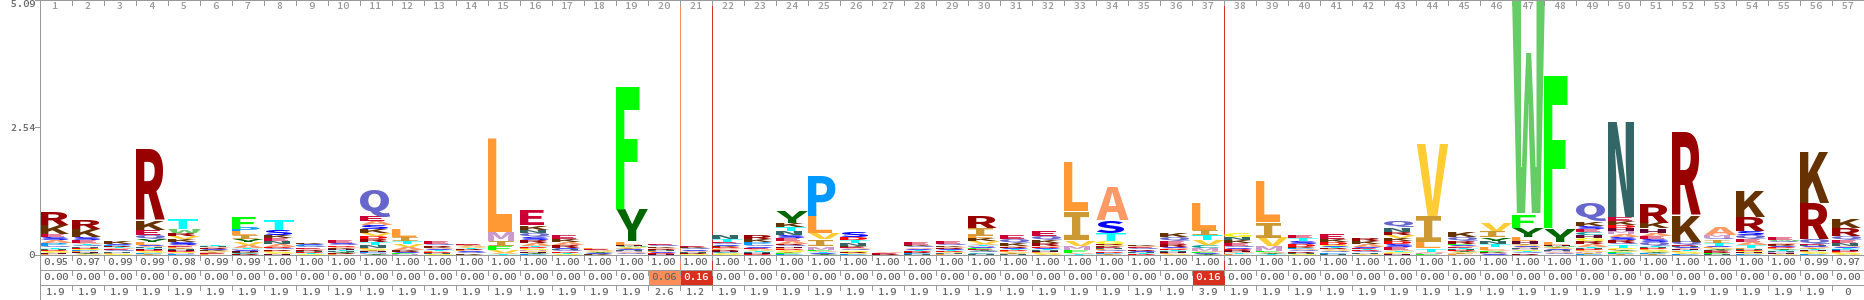

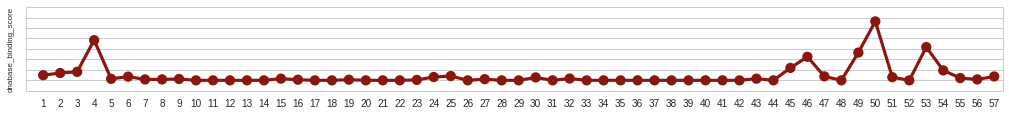

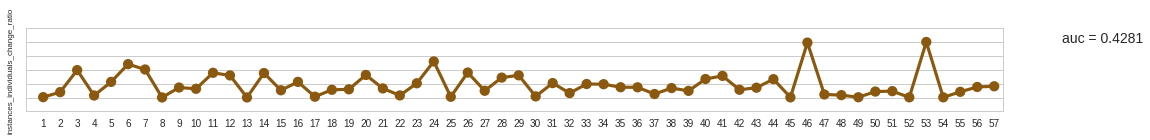

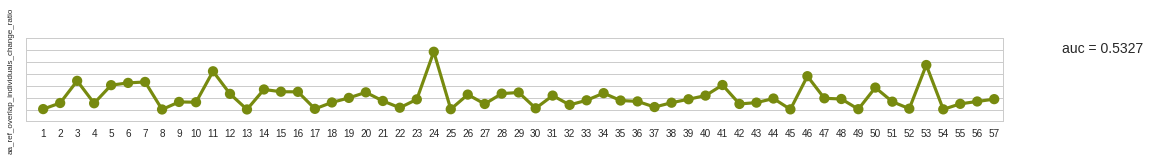

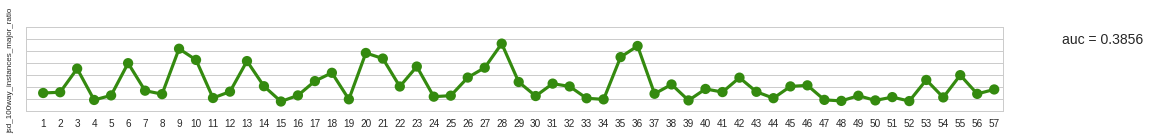

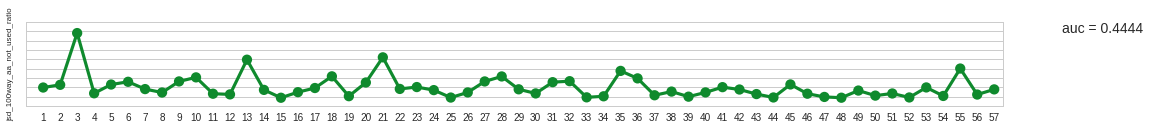

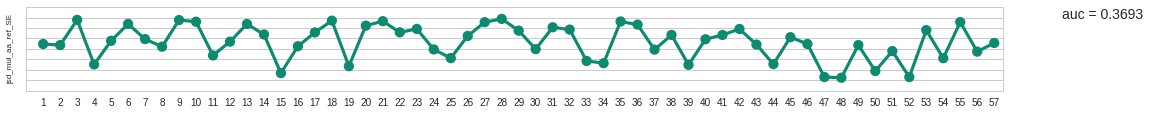

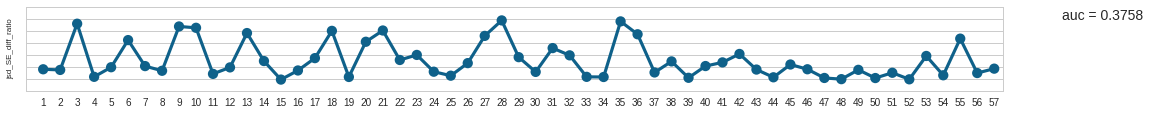

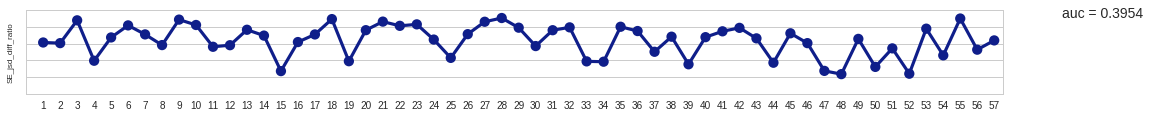

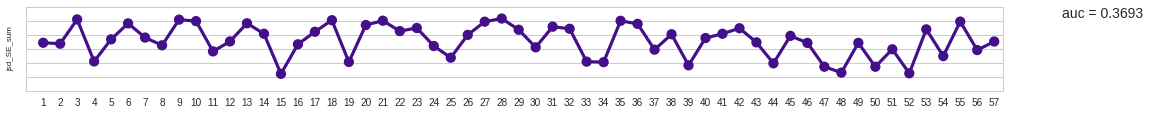

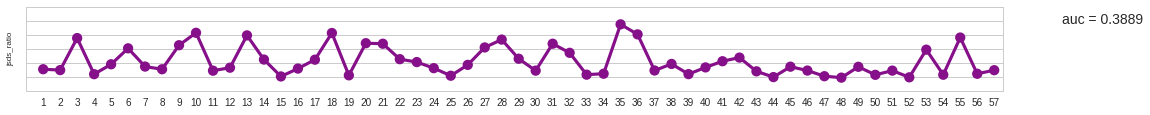

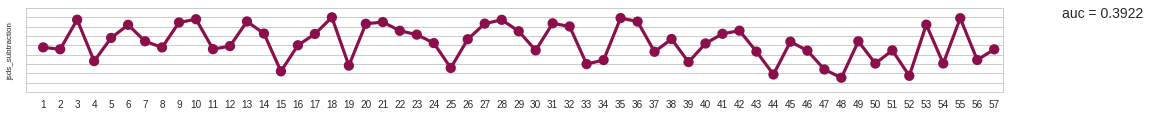

In [40]:
colors = sns.hls_palette(11, l=.3, s=.8)
sns.set(rc={'figure.figsize':(17.5,1.5)})
sns.set_style("whitegrid")
for i in range(len(scores_str)):
    plt.figure()
    ax = sns.pointplot(x="state", y=scores_str[i], data=sorted_domain_table, color=colors[i])
    ax.set_ylabel(scores_str[i], fontsize=8)
    ax.set_xlabel('')
    ax.set_yticklabels('')
    ax.set_xlim(xmin=-1)
    if (i > 0):
        y_loc = max(sorted_domain_table[scores_str[i]])
        x_loc = len(states) + 3
        auc_str = "auc = "+str(round(auc_list[i-1], 4))
        ax.text(x_loc, round(y_loc, 2),auc_str, fontsize=14)
    
Image(filename=logo_dir+domain_name+".png", width=1000)